# Figure 2

In [1]:
# Import packages.
import allel
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import zarr
# Print version numbers.
print('allel', allel.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('zarr', zarr.__version__)

allel 1.3.5
matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2
zarr 2.11.3


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})

In [3]:
# Define a function to exctract a genotype matrix for a specific haplotype region.
def load_hap_region():
    # Intialize the file path.
    path = './data/tgp_mod_arc_anc_748kb.zarr'
    # Load the zarr array.
    zarr_array = zarr.open_group(path, mode='r')
    # Extract the genotype callset.
    chr_callset = zarr_array['12/calldata/GT']
    # Load the positions.
    chr_pos = allel.SortedIndex(zarr_array['12/variants/POS'])
    # Extract the genotype matrix and positions array.
    hap_loc = chr_pos.locate_range(40758000, 40830000)
    hap_idx = np.where(((40758000 <= chr_pos) & (chr_pos <= 40830000)))[0]
    hap_gt = allel.GenotypeArray(chr_callset[hap_loc])
    hap_pos = chr_pos[hap_idx]
    return hap_gt, hap_pos

In [4]:
# Define a function to polarize a genotype matrix.
def polarize_gt(gt):
    # Extract and determine the ancestral sequence.
    anc_seq = np.mean(gt[:, -1, :], axis=1)
    # Intialize an empty genotype matrix.
    p_gt = np.empty_like(gt[:, :-1, :])
    # For every sample...
    for samp in range(gt[:, :-1, :].shape[1]):
        # Extract the haplotypes.
        hap_1 = gt[:, samp, 0]
        hap_2 = gt[:, samp, 1]
        # Polarize.
        p_hap_1 = np.where(anc_seq == 1, np.abs(hap_1 - 1), hap_1)
        p_hap_2 = np.where(anc_seq == 1, np.abs(hap_2 - 1), hap_2)
        # Build the polarized genotype matrix.
        p_gt[:, samp, 0] = np.where(p_hap_1 == 2, -1, p_hap_1)
        p_gt[:, samp, 1] = np.where(p_hap_2 == 2, -1, p_hap_2)
    # Intialize the polarized genotype matrix into sci-kit allele.
    polarized_gt = allel.GenotypeArray(p_gt)
    return polarized_gt

In [5]:
# Define a function to compute sequence divergence.
def sequence_divergence(px, py):
    # Calculate sequence divergence.
    seq_div = np.nansum(((px * (1 - py)) + (py * (1 - px))))
    return seq_div

In [6]:
# Define a function to calculate sequence divergence between archaic diplotypes and tgp haplotypes.
def tgp_haplotype_distances(p_gt):
    # Load the meta data.
    meta_df = pd.read_csv(
        './data/tgp_mod.txt', sep='\t',
        names=['IND', 'POP', 'SUPERPOP'],
    )
    # Load the effective sequence length matrix.
    esl_mat = np.loadtxt(
        './data/arc_and_tgp_72kb_eff_seq_len.csv',
        delimiter=',', dtype=int,
    )
    # Intialize archaic information dictionaries.
    freq_dicc = {
        'DEN': p_gt.take([2350], axis=1).count_alleles().to_frequencies()[:, 1],
        'ALT': p_gt.take([2347], axis=1).count_alleles().to_frequencies()[:, 1],
        'CHA': p_gt.take([2348], axis=1).count_alleles().to_frequencies()[:, 1],
        'VIN': p_gt.take([2349], axis=1).count_alleles().to_frequencies()[:, 1],
    }
    dist_dicc = {
        'DEN': {'hap_1': np.array([]), 'hap_2': np.array([])},
        'ALT': {'hap_1': np.array([]), 'hap_2': np.array([])},
        'CHA': {'hap_1': np.array([]), 'hap_2': np.array([])},
        'VIN': {'hap_1': np.array([]), 'hap_2': np.array([])},
    }
    esl_dicc = {
        'DEN': esl_mat[1, 3], 'ALT': esl_mat[1, 0],
        'CHA': esl_mat[1, 1], 'VIN': esl_mat[1, 2],
    }
    # Intialize data frame dictionaries.
    abs_dicc = {
        'Sample': meta_df['IND'].values,
        'Population': meta_df['POP'].values,
        'Super Population': meta_df['SUPERPOP'].values,
        'Hap. 1 (DEN)': [], 'Hap. 2 (DEN)': [],
        'Hap. 1 (ALT)': [], 'Hap. 2 (ALT)': [],
        'Hap. 1 (CHA)': [], 'Hap. 2 (CHA)': [],
        'Hap. 1 (VIN)': [], 'Hap. 2 (VIN)': [],
    }
    norm_dicc = {
        'Sample': meta_df['IND'].values,
        'Population': meta_df['POP'].values,
        'Super Population': meta_df['SUPERPOP'].values,
        'Hap. 1 (DEN)': [], 'Hap. 2 (DEN)': [],
        'Hap. 1 (ALT)': [], 'Hap. 2 (ALT)': [],
        'Hap. 1 (CHA)': [], 'Hap. 2 (CHA)': [],
        'Hap. 1 (VIN)': [], 'Hap. 2 (VIN)': [],
    }
    # Extract haplotype arrays.
    tgp_hap_1 = p_gt[:, :-4, 0]
    tgp_hap_2 = p_gt[:, :-4, 1]
    # For every archaic individual...
    for arc in ['DEN', 'ALT', 'CHA', 'VIN']:
        # Determine the number of called sites and update the dictionary.
        n_sites = esl_dicc[arc]
        dist_dicc[arc]['n_sites'] = n_sites
        # For every tgp sample...
        for samp in range(p_gt[:, :-4, :].shape[1]):
            # Extract the sample's haplotypes.
            hap_1 = tgp_hap_1[:, samp]
            hap_2 = tgp_hap_2[:, samp]
            # Compute the distance from the archaic diplotype.
            dist_1 = sequence_divergence(hap_1, freq_dicc[arc])
            dist_2 = sequence_divergence(hap_2, freq_dicc[arc])
            # Update dictionaries.
            dist_dicc[arc]['hap_1'] = np.append(dist_dicc[arc]['hap_1'], dist_1)
            dist_dicc[arc]['hap_2'] = np.append(dist_dicc[arc]['hap_2'], dist_2)
            abs_dicc['Hap. 1 ({0})'.format(arc)].append(dist_1)
            abs_dicc['Hap. 2 ({0})'.format(arc)].append(dist_2)
            norm_dicc['Hap. 1 ({0})'.format(arc)].append(dist_1/n_sites)
            norm_dicc['Hap. 2 ({0})'.format(arc)].append(dist_2/n_sites)
    # Intailize the dataframes.
    abs_df = pd.DataFrame(data=abs_dicc)
    norm_df = pd.DataFrame(data=norm_dicc)
    return abs_df, norm_df

In [7]:
# Load the genotype matrix.
tgp_72kb_gt, _ = load_hap_region()
# Polarize the genotype matrix
tgp_72kb_p_gt = polarize_gt(tgp_72kb_gt)

In [8]:
# Compute the haplotype distances.
tgp_72kb_abs_dist_df, tgp_72kb_norm_dist_df = tgp_haplotype_distances(tgp_72kb_p_gt)

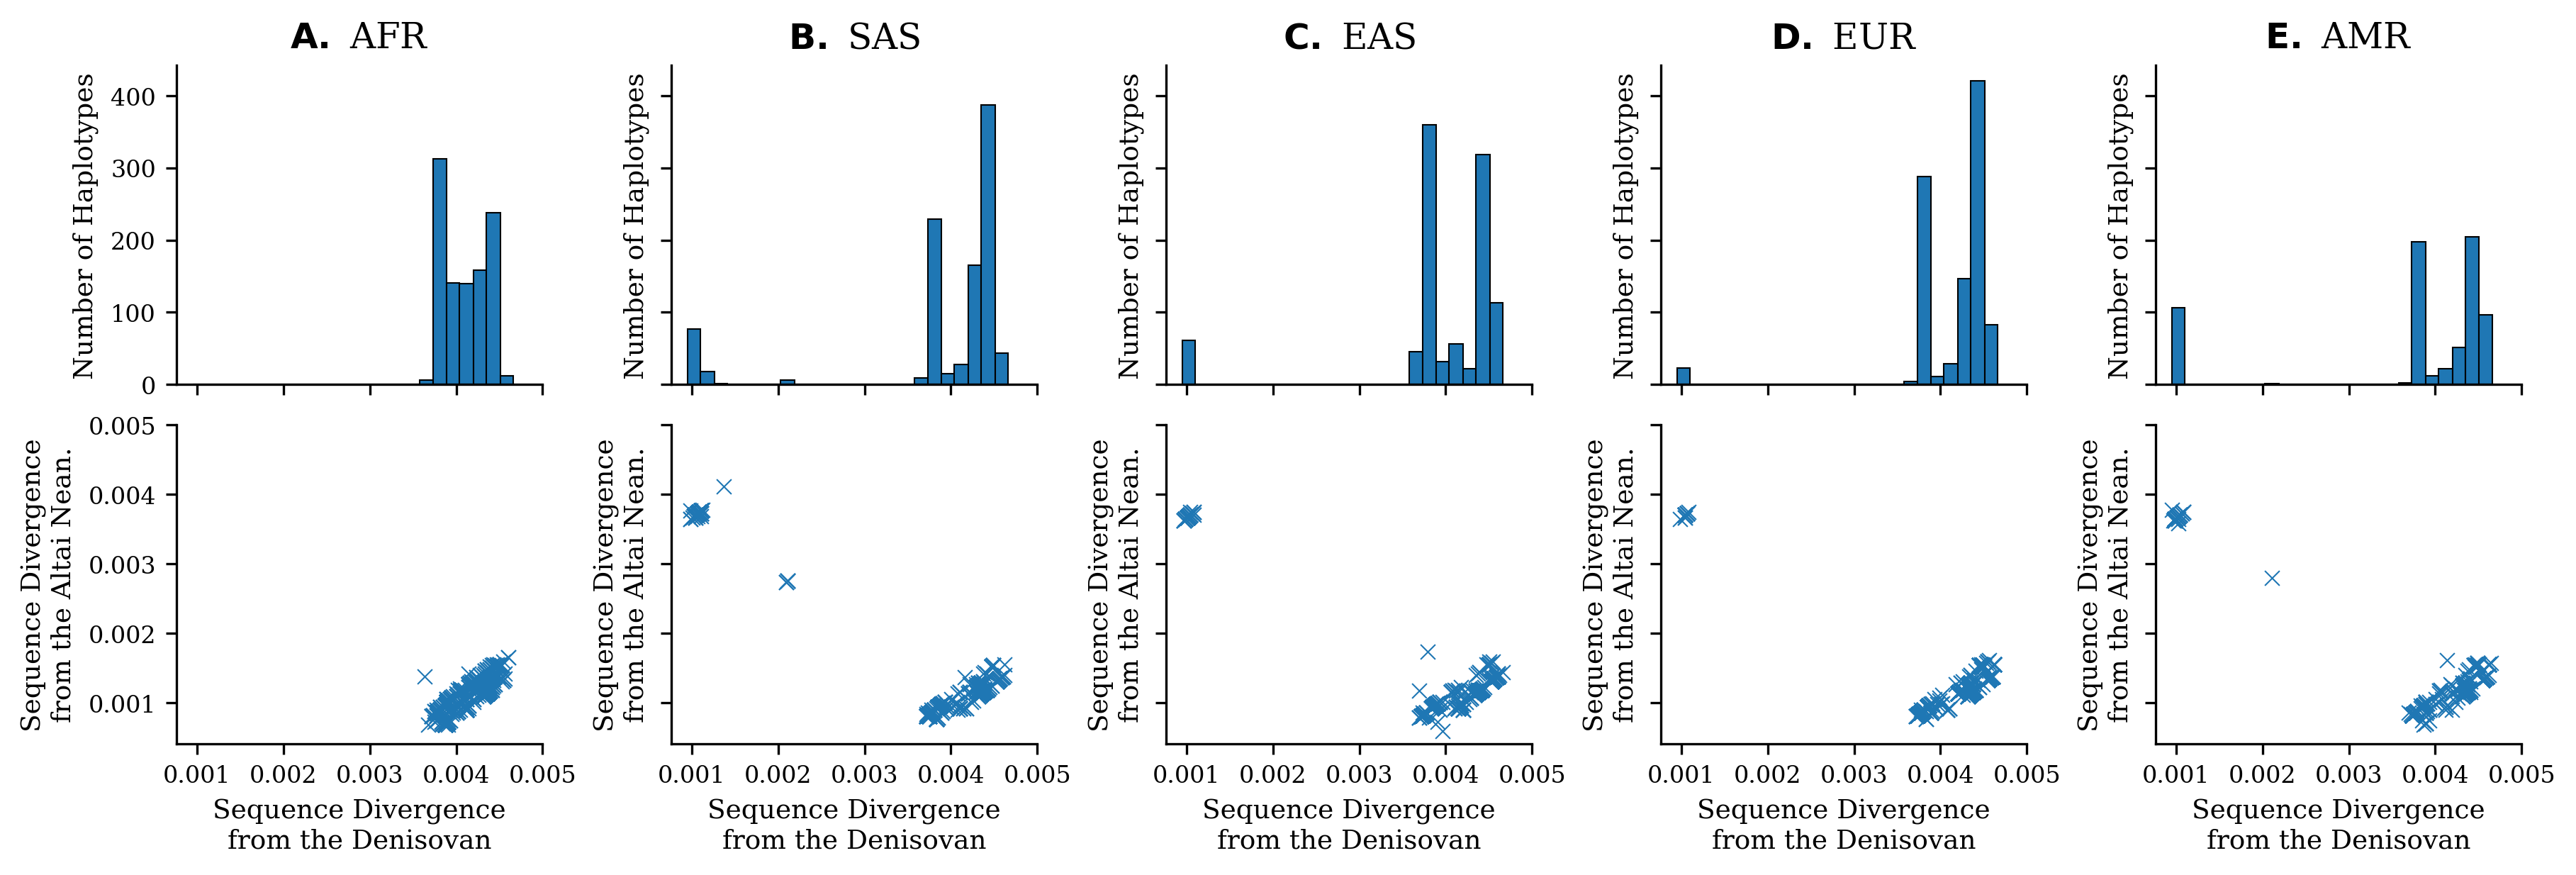

In [9]:
# Intialize figures and axes.
fig, axes = plt.subplots(
     2, 5, figsize=(12, 4),
    sharex=True, sharey='row', dpi=300,
)
# Intialize a super population list.
s_pop_list = ['AFR', 'SAS', 'EAS', 'EUR', 'AMR']
# Intialize a prefix list.
prefix_list = [r'$\bf{A.}$ ', r'$\bf{B.}$ ', r'$\bf{C.}$ ', r'$\bf{D.}$ ', r'$\bf{E.}$ ']
# Intialize a columns list.
cols = [
    0, 1, 2, 3, 4,
]
# Determine the max and min distance from the Denisovan.
max_dist = tgp_72kb_norm_dist_df[['Hap. 1 (DEN)', 'Hap. 2 (DEN)']].max().max()
min_dist = tgp_72kb_norm_dist_df[['Hap. 1 (DEN)', 'Hap. 2 (DEN)']].min().min()
# For every super population...
for idx in range(len(s_pop_list)):
    # Extract the super population.
    s_pop = s_pop_list[idx]
    # Extract the haplotype distances for the Denisovan and Neanderthals.
    den_1 = tgp_72kb_norm_dist_df[tgp_72kb_norm_dist_df['Super Population'].isin([s_pop])]['Hap. 1 (DEN)'].values
    den_2 = tgp_72kb_norm_dist_df[tgp_72kb_norm_dist_df['Super Population'].isin([s_pop])]['Hap. 2 (DEN)'].values
    den_dists = np.concatenate((den_1, den_2))
    alt_1 = tgp_72kb_norm_dist_df[tgp_72kb_norm_dist_df['Super Population'].isin([s_pop])]['Hap. 1 (ALT)'].values
    alt_2 = tgp_72kb_norm_dist_df[tgp_72kb_norm_dist_df['Super Population'].isin([s_pop])]['Hap. 2 (ALT)'].values
    alt_dists = np.concatenate((alt_1, alt_2))
    # Plot the haplotype distribution.
    axes[0, cols[idx]].hist(
        den_dists, bins=np.round(np.linspace(min_dist, max_dist, 25), 5),
        color='tab:blue', histtype='bar', edgecolor='black', linewidth=0.5,
    )
    # Plot the distance from the Denisovan vs distance from the Altai Nean.
    axes[1, cols[idx]].scatter(
        den_dists, alt_dists, color='tab:blue',
        marker='x', linewidths=0.5, s=25,
    )
    # Adjust the ticks.
    axes[1, cols[idx]].set_yticks(
        np.linspace(0.001, 0.005, 5),
    )
    axes[1, cols[idx]].set_xticks(
        np.linspace(0.001, 0.005, 5),
    )
    # Adjust the  tick size.
    axes[0, cols[idx]].tick_params(axis='y', labelsize=8)
    axes[1, cols[idx]].tick_params(axis='y', labelsize=8)
    axes[0, cols[idx]].tick_params(axis='x', labelsize=8)
    axes[1, cols[idx]].tick_params(axis='x', labelsize=8)
    # Add x-axes labels.
    axes[1, cols[idx]].set_xlabel('Sequence Divergence'+'\n'+'from the Denisovan', size=9)
    # Add the y-axes labels.
    axes[0, cols[idx]].set_ylabel('Number of Haplotypes', size=9)
    axes[1, cols[idx]].set_ylabel('Sequence Divergence'+'\n'+'from the Altai Nean.', size=9)
    # Intialize and add a title.
    title = prefix_list[idx]+s_pop
    axes[0, cols[idx]].set_title(title)
# Export the plot.
plt.savefig(
    './figures/figure_2.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot.
plt.show()